Create images & videos out of saved generation data

# Imports

In [1]:
import multiprocessing
import sys
import tempfile
from pathlib import Path

import imageio
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from IPython.display import HTML, display
from matplotlib.gridspec import GridSpec
from moviepy.editor import ImageSequenceClip
from PIL import Image
from torch import Tensor

sys.path.append(str(Path("..").resolve()))

from GaussianProxy.utils.misc import _normalize_elements_for_logging

In [2]:
torch.set_grad_enabled(False)

# Experiment

In [3]:
root_experiments_path = Path("/", "projects", "static2dynamic", "Thomas", "experiments")

In [6]:
project_name = "GaussianProxy"
run_name = "ChromaLIVE_6hr_all_times_paired"

In [7]:
project_path = root_experiments_path / project_name
assert project_path.exists(), f"Project path {project_path} does not exist."

run_path = project_path / run_name
assert run_path.exists(), f"Run path {run_path} does not exist."

output_dir = Path(".", "artifacts_viz_outputs", project_name, run_name)
output_dir.mkdir(exist_ok=True, parents=True)
print("output dir:", output_dir)

output dir: artifacts_viz_outputs/GaussianProxy/all_times


# Show images from saved tensors

## Inverted regens

In [22]:
imgs_path = run_path / "saved_artifacts" / "InvertedRegeneration" / "starting_samples"
assert imgs_path.exists(), f"Vids path {imgs_path} does not exist."
all_trajs = list(imgs_path.rglob("*.pt"))
all_trajs = [x for x in all_trajs if "proc_0" in x.name]

print(f"Found {len(all_trajs)} starting image tensor generated by process 0.")
last_traj_path = all_trajs[-1]
print(f"Last trajectory: {last_traj_path.name}")

Found 2 starting image tensor generated by process 0.
Last trajectory: step_40000_proc_0.pt


In [23]:
last_img = torch.load(last_traj_path, map_location="cpu")
print(f"Loaded image tensor with shape {last_img.shape}, dtype {last_img.dtype} on cpu")

Loaded image tensor with shape torch.Size([16, 3, 196, 196]), dtype torch.float16 on cpu


In [24]:
nomrd_imgs = _normalize_elements_for_logging(
    last_img,
    ["image min-max", "-1_1 raw", "-1_1 clipped"],
)

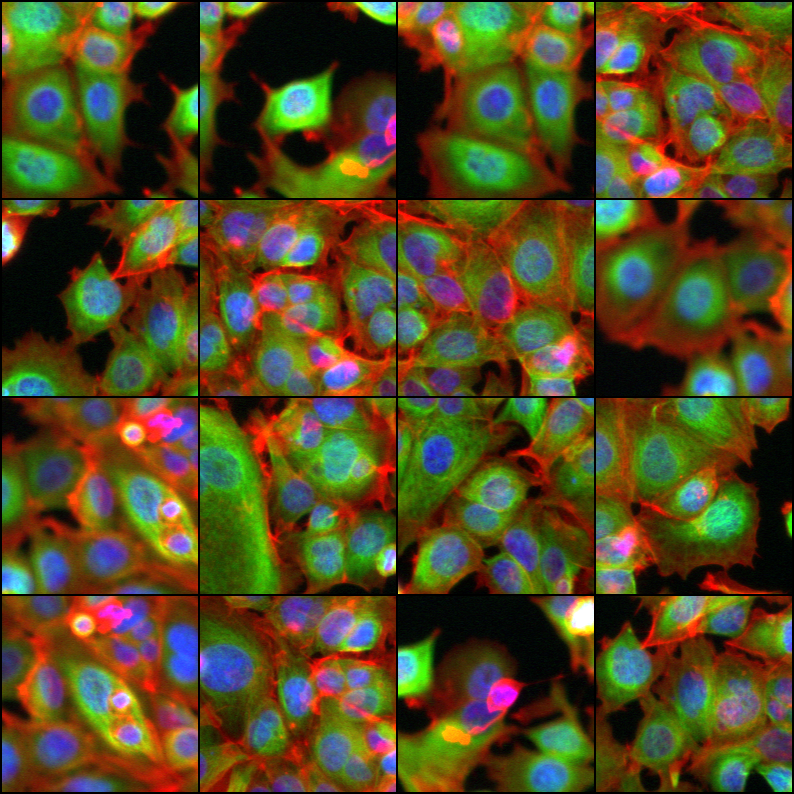

In [25]:
tensor = nomrd_imgs["-1_1 raw"]
# Convert tensor to a grid of images
grid_img = torchvision.utils.make_grid(torch.from_numpy(tensor), nrow=4)

# Convert to PIL Image
pil_img = Image.fromarray(grid_img.numpy().transpose(1, 2, 0))
display(pil_img)

# Show video of trajectories

## from training logs

In [8]:
vids_path = run_path / "saved_artifacts" / "InvertedRegeneration" / "trajectories"

assert vids_path.exists(), f"Vids path {vids_path} does not exist."
all_trajs = list(vids_path.rglob("*.pt"))
all_trajs = [x for x in all_trajs if "proc_0" in x.name]

print(f"Found {len(all_trajs)} trajectories generated by process 0.")
last_traj_path = all_trajs[-1]
print(f"Last trajectory: {last_traj_path.name}")

## from offline evaluation

In [12]:
vids_path = run_path / "inference_tests" / "InvertedRegeneration" / "trajectories.pt"
assert vids_path.exists(), f"Vids path {vids_path} does not exist."
last_traj_path = vids_path

In [13]:
last_traj = torch.load(last_traj_path, map_location="cpu")
print(f"Loaded trajectory with shape {last_traj.shape}, dtype {last_traj.dtype} on cpu")

Loaded trajectory with shape torch.Size([30, 64, 3, 128, 128]), dtype torch.float32 on cpu


In [17]:
nomrd_vids = _normalize_elements_for_logging(
    last_traj,
    ["-1_1 raw"],
)
print(f"Normalized trajectory with shape {nomrd_vids['-1_1 raw'].shape}")

Normalized trajectory with shape (30, 64, 3, 128, 128)


In [20]:
gen_traj_index = 1  # what sample to visualize (sample = video)
batch_dim_idx = 1  # which dimension is the batch dimension

In [24]:
indexing = [slice(None)] * nomrd_vids["-1_1 raw"].ndim
indexing[batch_dim_idx] = gen_traj_index
indexing = tuple(indexing)
indexing

(slice(None, None, None),
 1,
 slice(None, None, None),
 slice(None, None, None),
 slice(None, None, None))

In [ ]:
for norm_method, vid in nomrd_vids.items():
    print(
        f"Norm method: {norm_method} | saved data shape: {vid.shape} | selected video sample shape: {vid[indexing].shape}"
    )
    # Convert np array to video
    video_save_path = Path(output_dir, f"{norm_method}.mp4")
    imageio.mimwrite(video_save_path, vid[indexing].transpose(0, 2, 3, 1), fps=1)
    print(f"Saved video to {video_save_path}")

    # Display the video with a specific width
    display(HTML(f'<video width="300" controls><source src="{video_save_path}" type="video/mp4"></video>'))

Norm method: -1_1 raw | saved data shape: (30, 64, 3, 128, 128) | selected video sample shape: (30, 3, 128, 128)
Saved video to artifacts_viz_outputs/GaussianProxy/all_times/-1_1 raw.mp4


# frame-by-frame

In [34]:
vid = nomrd_vids["-1_1 raw"][indexing]
print(f"Selected video shape: {vid.shape}")

frames_save_path = output_dir / f"frames_{norm_method}"
frames_save_path.mkdir(exist_ok=True, parents=True)

for frame_idx, frame in enumerate(vid):
    img = Image.fromarray(frame.transpose(1, 2, 0))
    img.save(frames_save_path / f"{frame_idx}.png")

Selected video shape: (30, 3, 128, 128)


# Video grid

In [32]:
def tensor_transformation(t: Tensor, norm: str | None, img_size: int) -> Tensor:
    assert t.ndim == 4, f"Expected 4D tensor, got {t.ndim}D tensor"
    assert t.shape[2] == t.shape[3], f"Expected square image, got {t.shape}"
    match norm:
        case "clip[-1;1]":
            # clip to [-1:1] and move to [0;1]
            t = t.clip(-1, 1)
            t /= 2
            t += 0.5
        case "min-max":
            # min-max normalize to move to [0;1]
            t -= t.amin(dim=(1, 2, 3), keepdim=True)
            t /= t.amax(dim=(1, 2, 3), keepdim=True)
        case "min-max_across_times":
            # min-max normalize and move to [0;1]
            t -= t.min()
            t /= t.max()
        case "min-95perc_across_times":
            # min-max normalize to move to [0;1]
            t -= t.min()
            t = t.clip(0, t.to(torch.float32).quantile(0.95).item())
            t /= t.max()
        case None | "None":
            # do nothing and let Matplotlib *clip* to [0; 1]
            pass
        case "old log":
            t = (t.cpu().numpy() * 255).astype(np.uint8)
        case _:
            raise ValueError
    # resize to img_size
    if t.shape[2] != img_size:
        print(f"Resizing from {t.shape[2]} to {img_size}")
        t = F.interpolate(t, size=(img_size, img_size), mode="bilinear", align_corners=False)
    # order dims for matplotlib
    t = t.permute(0, 2, 3, 1)
    # convert to fp32 for matplotlib
    t = t.to(torch.float32)
    return t


def process_index(tensor: Tensor, idx: int, norm_method: str | None, img_size: int) -> Tensor:
    assert tensor.ndim == 5, f"Expected 5D tensor, got {tensor.ndim}D tensor"
    img = tensor_transformation(tensor[idx, ...], norm_method, img_size)
    return img

In [33]:
def save_frame(t: int, images: list[Tensor], temp_dir: str, nrows: int, ncols: int, tick_values: list[float]):
    fig = plt.figure(layout="constrained", figsize=(nrows * 2 + 0.2, ncols * 2))  # nrows * ncols vids + 1 progress bar
    fig.patch.set_facecolor("black")
    title = fig.suptitle(f"Time: {t}/{(len(images[0]) - 1)}")
    title.set_color("white")
    height_ratios = [1] * nrows + [0.2]  # 0.5 for the progress bar row
    gs = GridSpec(nrows + 1, ncols, figure=fig, height_ratios=height_ratios)

    # Create a progress bar artist
    progress_bar = patches.Rectangle((0, 0.45), t / (len(images[0]) - 1), 0.1, facecolor="white")
    progress_ax = fig.add_subplot(gs[nrows, :])  # Add progress bar to the bottom row
    progress_ax.add_patch(progress_bar)
    progress_ax.set_xticks(tick_values)
    progress_ax.get_yaxis().set_visible(False)
    progress_ax.xaxis.set_tick_params(width=2, color="white")
    progress_ax.set_facecolor("black")
    progress_ax.set_xticklabels([str(idx + 1) for idx in range(len(tick_values))], color="white")

    for row in range(nrows):
        for col in range(ncols):
            ax = fig.add_subplot(gs[row, col])
            ax.imshow(images[row * nrows + col][t])
            ax.axis("off")

    # Save the frame as an image
    plt.savefig(f"{temp_dir}/frame_{t}.png")
    plt.close()


def create_image_sequence_video(
    tensor_path: Path,
    norm_method: str | None,
    tick_values: list[float],
    sample_idx: list[int] | None = None,
    img_size: int = 128,
    nrows: int = 4,
    ncols: int = 4,
):
    # Load tensor
    tensor = torch.load(tensor_path).cpu()
    print(f"Loaded tensor of shape {tensor.shape}")

    print(f"Using norm method: {norm_method}, image_size: {img_size}")

    sel_samples = sample_idx if sample_idx is not None else list(range(nrows * ncols))
    with multiprocessing.Pool() as pool:
        images = pool.starmap(process_index, [(tensor, idx, norm_method, img_size) for idx in sel_samples])

    print(f"Processed images; got: len(images): {len(images)}; images[0].shape: {images[0].shape}")

    # Create a temporary directory
    with tempfile.TemporaryDirectory() as temp_dir:
        with multiprocessing.Pool() as pool:
            pool.starmap(save_frame, [(t, images, temp_dir, nrows, ncols, tick_values) for t in range(len(images[0]))])

        # Compile the frames into a video using imageio
        frames = [f"{temp_dir}/frame_{i}.png" for i in range(len(images[0]))]
        print(f"Saved {len(frames)} frames: {frames}")
        assert len(frames) == len(images[0]), f"Expected {len(images[0])} frames, got {len(frames)}"

        save_path = Path(
            "make_traj_vids_saved_plots", project_name, run_name, f"{tensor_path.stem}_{norm_method}_norm.mp4"
        )
        save_path.parent.mkdir(parents=True, exist_ok=True)

        print(f"Saving videos to {save_path}...")
        fps = max(int(len(images[0]) / 10), 1)
        clip = ImageSequenceClip(frames, fps=fps)
        clip.write_videofile(save_path.as_posix(), threads=4)

    print(f"Saved videos to {save_path}")

In [34]:
ticks_pos = [0.0, 0.2531645596027374, 0.5063291192054749, 0.7468354105949402, 1.0]

In [35]:
create_image_sequence_video(last_traj_path, "min-max", ticks_pos)

Loaded tensor of shape torch.Size([16, 50, 3, 196, 196])
Using norm method: min-max, image_size: 128
Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128








Resizing from 196 to 128
Resizing from 196 to 128

Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128

Processed images; got: len(images): 16; images[0].shape: torch.Size([50, 128, 128, 3])
Saved 50 frames: ['/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_0.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_1.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_2.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_3.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_4.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_5.png', '/localtmp/tboyer/.tmpdir/tmpsq9hytly/frame_6.png', '/localtmp/tboyer/.tmpdir/tmps

Moviepy - Done !
Moviepy - video ready make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_min-max_norm.mp4
Saved videos to make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_min-max_norm.mp4


In [36]:
create_image_sequence_video(last_traj_path, "None", ticks_pos)

Loaded tensor of shape torch.Size([16, 50, 3, 196, 196])
Using norm method: None, image_size: 128
Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128

Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128






Processed images; got: len(images): 16; images[0].shape: torch.Size([50, 128, 128, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9980469..0.9921875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9980469..0.97021484].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9902344..0.98291016].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9980469..0.99121094].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99560547..0.9741211].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9980469..0.96875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9975

Saved 50 frames: ['/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_0.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_1.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_2.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_3.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_4.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_5.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_6.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_7.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_8.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_9.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_10.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_11.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_12.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_13.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_14.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_15.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_16.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/frame_17.png', '/localtmp/tboyer/.tmpdir/tmp17q5qfdk/

Moviepy - Done !
Moviepy - video ready make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_None_norm.mp4
Saved videos to make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_None_norm.mp4


In [37]:
create_image_sequence_video(last_traj_path, "min-max_across_times", ticks_pos)

Loaded tensor of shape torch.Size([16, 50, 3, 196, 196])
Using norm method: min-max_across_times, image_size: 128
Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128


Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128





Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128

Resizing from 196 to 128
Processed images; got: len(images): 16; images[0].shape: torch.Size([50, 128, 128, 3])
Saved 50 frames: ['/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_0.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_1.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_2.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_3.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_4.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_5.png', '/localtmp/tboyer/.tmpdir/tmpx_fhu8pu/frame_6.png', '/localtmp/tboyer

Moviepy - Done !
Moviepy - video ready make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_min-max_across_times_norm.mp4
Saved videos to make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_min-max_across_times_norm.mp4


In [38]:
create_image_sequence_video(last_traj_path, "clip[-1;1]", ticks_pos)

Loaded tensor of shape torch.Size([16, 50, 3, 196, 196])
Using norm method: clip[-1;1], image_size: 128
Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128Resizing from 196 to 128

Resizing from 196 to 128

Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128

Resizing from 196 to 128Resizing from 196 to 128

Resizing from 196 to 128
Resizing from 196 to 128Resizing from 196 to 128

Resizing from 196 to 128Resizing from 196 to 128
Resizing from 196 to 128

Processed images; got: len(images): 16; images[0].shape: torch.Size([50, 128, 128, 3])
Saved 50 frames: ['/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_0.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_1.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_2.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_3.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_4.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_5.png', '/localtmp/tboyer/.tmpdir/tmpu0bmar4g/frame_6.png', '/localtmp/tboyer/.tmpdir/t

Moviepy - Done !
Moviepy - video ready make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_clip[-1;1]_norm.mp4
Saved videos to make_traj_vids_saved_plots/GaussianProxy/BBBC021_196_docetaxel_12M_net/step_20000_proc_0_clip[-1;1]_norm.mp4
